## Original Gdino

In [245]:
from absl import app, logging
from PIL import Image as PILImg
from PIL import ImageFilter
import PIL.ImageOps
from robokit.utils import overlay_masks
from robokit.ObjDetection import GroundingDINOObjectPredictor, SegmentAnythingPredictor
import torch

# image_path = 'D:/CODE/NIDS-Net/test_data/test_1/test_039.jpg'
image_path = "C:/dataset/OCID/YCB10/floor/top/curved/seq11/rgb/result_2018-08-24-11-53-30.png"
# "C:/dataset/OCID/YCB10/table/top/mixed/seq32/rgb/result_2018-08-24-14-41-08.png"

In [246]:
from absl import app, logging
from PIL import Image as PILImg
from PIL import ImageFilter
import PIL.ImageOps
from robokit.utils import annotate, overlay_masks
from robokit.ObjDetection import GroundingDINOObjectPredictor
import torch 
gdino = GroundingDINOObjectPredictor(use_vitb=False, box_threshold=0.15, text_threshold=0.15)
import matplotlib.pyplot as plt
# Path to the input image

text_prompt = 'objects'

try:
    logging.info("Open the image and convert to RGB format")
    image_pil = PILImg.open(image_path).convert("RGB")
    
    logging.info("GDINO: Predict bounding boxes, phrases, and confidence scores")
    bboxes, phrases, gdino_conf = gdino.predict(image_pil, text_prompt)

    logging.info("GDINO post processing")
    w, h = image_pil.size # Get image width and height 
    # Scale bounding boxes to match the original image size
    image_pil_bboxes = gdino.bbox_to_scaled_xyxy(bboxes, w, h)  
    
    # logging.info("SAM: Predict")
    # image_pil_bboxes, masks = SAM.predict(image_pil, image_pil_bboxes)
    # print(masks.shape)
    
    # print(image_pil_bboxes)
    logging.info("Annotate the scaled image with bounding boxes, confidence scores, and labels, and display")
    bbox_annotated_pil = annotate(image_pil, image_pil_bboxes, gdino_conf, phrases)
    bbox_annotated_pil.show()
    # plt.figure(figsize=(50,20))
    # plt.imshow(bbox_annotated_pil)
    del image_pil_bboxes
    torch.cuda.empty_cache()

except Exception as e:
    # Handle unexpected errors
    print(f"An unexpected error occurred: {e}")

final text_encoder_type: bert-base-uncased


INFO:absl:Open the image and convert to RGB format
INFO:absl:GDINO: Predict bounding boxes, phrases, and confidence scores


Model loaded from C:\Users\divya\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


INFO:absl:GDINO post processing
INFO:absl:Annotate the scaled image with bounding boxes, confidence scores, and labels, and display


## Sliding Window

In [1]:
# Code from https://github.com/niconielsen32/tiling-window-detection/blob/main/tiling.py

# *Mine*
# Image Width: 8192 | Image Height:6144 | Slice Height: 2048 | Slice Width: 1536

import cv2
from typing import Dict, List, Optional, Sequence, Tuple, Union
import numpy as np
from PIL import Image
import time
from absl import app, logging
from PIL import Image as PILImg
from PIL import ImageFilter
import PIL.ImageOps
from robokit.utils import overlay_masks
from robokit.ObjDetection import GroundingDINOObjectPredictor, SegmentAnythingPredictor
import torch

from utils.sliding_window import slice_image, get_slice_bboxes
from utils.changed_fn import area, annotate, get_object_proposal

In [3]:
gdino = GroundingDINOObjectPredictor(use_vitb=False, box_threshold=0.2, text_threshold=0.2) # 0.2
# SAM = SegmentAnythingPredictor(vit_model="vit_h")

final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\divya\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [4]:
# image_path = "C:/dataset/OCID/ARID20/table/bottom/seq09/rgb/result_2018-08-21-15-58-00.png"      # ✅
# image_path = "C:/dataset/OCID/YCB10/floor/top/curved/seq11/rgb/result_2018-08-24-11-53-30.png"   # ✅
# image_path = 'D:/CODE/NIDS-Net/test_data/test_1/test_039.jpg'                                    # ✅
# image_path = "C:/dataset/OCID/ARID10/table/top/fruits/seq20/rgb/result_2018-08-23-13-53-58.png"  # ✅
# image_path = "C:/dataset/OCID/YCB10/table/top/mixed/seq32/rgb/result_2018-08-24-14-41-08.png"    # ✅ 
# image_path = 'D:/CODE/NIDS-Net/imgs/clutter-test.png'                                            # ✅ 
# image_path = "C:/dataset/InsDet-FULL/Data/test_1_all/images/test_042.jpg"
image_path = "C:/dataset/InsDet-FULL/Data/test_1_all/images/test_154.jpg"

In [5]:
image_pil = PILImg.open(image_path).convert("RGB")

wd, ht = image_pil.size
if wd!=8192 and ht!=6144:
    image_pil = PILImg.open(image_path).convert("RGB").resize(((8192//4)*2, (6144//4)*2), PIL.Image.BILINEAR) # Read Img

    image = Image.new(image_pil.mode, (8192, 6144), (225, 225, 255))
    image.paste(image_pil, (8192//4, 6144//4)) 

    # image = PILImg.open(image_path).convert("RGB").resize((8192, 6144), PIL.Image.NEAREST) # Read Img
else:
    image=image_pil


width, height = image.size # Get size of Image
slice_height = height // 2
slice_width = width // 2
overlap_ratio_h=0.2
overlap_ratio_w=0.2
# Create a
slice_image_result = slice_image(
            image=image,
            slice_height=slice_height,
            slice_width=slice_width,
            overlap_height_ratio=overlap_ratio_h,
            overlap_width_ratio=overlap_ratio_w,
            auto_slice_resolution=False,
        )

number_of_tiles = len(slice_image_result)
print(f"{number_of_tiles} Tiles are created for the image")



9 Tiles are created for the image


In [6]:
all_windows = get_slice_bboxes(
    image_height=height,
    image_width=width,
    slice_height=slice_height,
    slice_width=slice_width,
    auto_slice_resolution=True,
    overlap_height_ratio=overlap_ratio_h,
    overlap_width_ratio=overlap_ratio_w)

In [7]:
all_bboxes = []
all_confs = []
all_phrases = []
# all_masks=[]
window_id=[]
text_prompt = 'objects'
# threshold = 3

for i, image_slice in enumerate(slice_image_result):

    window = PILImg.fromarray(image_slice['image'])
    start_x, start_y = image_slice['starting_pixel']
    bboxes, phrases, gdino_conf = gdino.predict(window, text_prompt)
    w, h = window.size
    xyxy = gdino.bbox_to_scaled_xyxy(bboxes, w, h).detach().cpu().numpy()
    print(f"{i}) {xyxy.shape} Bbox's Shape")
    # xyxy, masks = SAM.predict(window, xyxy)
    #     
    confs = gdino_conf.detach().cpu().numpy()
    torch.cuda.empty_cache()

    for k in range(len(xyxy)):
        x1, y1, x2, y2 = xyxy[k]

        x1 += start_x
        y1 += start_y
        x2 += start_x
        y2 += start_y

        x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

        s=area([x1, y1, x2, y2])
        b=area(all_windows[i])
        ratio=int((s/b)*100)
        print("bbox: ", [x1, y1, x2, y2]," ratio : ", ratio)
        if ratio>20:
            continue

        all_bboxes.append([x1, y1, x2, y2])
        all_confs.append(confs[k])
        all_phrases.append(phrases[k])
        window_id.append(i)
        # all_masks.append(masks[_])

0) (11, 4) Bbox's Shape
bbox:  [3430, 2253, 3794, 2784]  ratio :  1
bbox:  [10, 0, 4087, 2137]  ratio :  69
bbox:  [2137, 2986, 2361, 3070]  ratio :  0
bbox:  [2692, 238, 3575, 2091]  ratio :  13
bbox:  [433, 0, 1679, 1955]  ratio :  19
bbox:  [1655, 6, 2706, 2033]  ratio :  16
bbox:  [5, 1835, 4090, 3068]  ratio :  40
bbox:  [3102, 3026, 3257, 3071]  ratio :  0
bbox:  [3567, 437, 4090, 2128]  ratio :  7
bbox:  [2138, 2988, 2239, 3070]  ratio :  0
bbox:  [3, 1, 466, 1865]  ratio :  6
1) (8, 4) Bbox's Shape
bbox:  [5278, 2774, 5550, 2902]  ratio :  0
bbox:  [5775, 2848, 6090, 3068]  ratio :  0
bbox:  [6972, 733, 7369, 1120]  ratio :  1
bbox:  [4138, 2795, 4760, 3067]  ratio :  1
bbox:  [4751, 2943, 4884, 3068]  ratio :  0
bbox:  [5244, 2899, 5833, 3068]  ratio :  0
bbox:  [4522, 2818, 4753, 3063]  ratio :  0
bbox:  [3284, 372, 6098, 2259]  ratio :  42
2) (10, 4) Bbox's Shape
bbox:  [7492, 564, 7954, 962]  ratio :  1
bbox:  [5281, 2774, 5549, 2902]  ratio :  0
bbox:  [6974, 735, 7462, 11

In [8]:
len(all_bboxes), len(all_confs), len(all_phrases), len(window_id)

(141, 141, 141, 141)

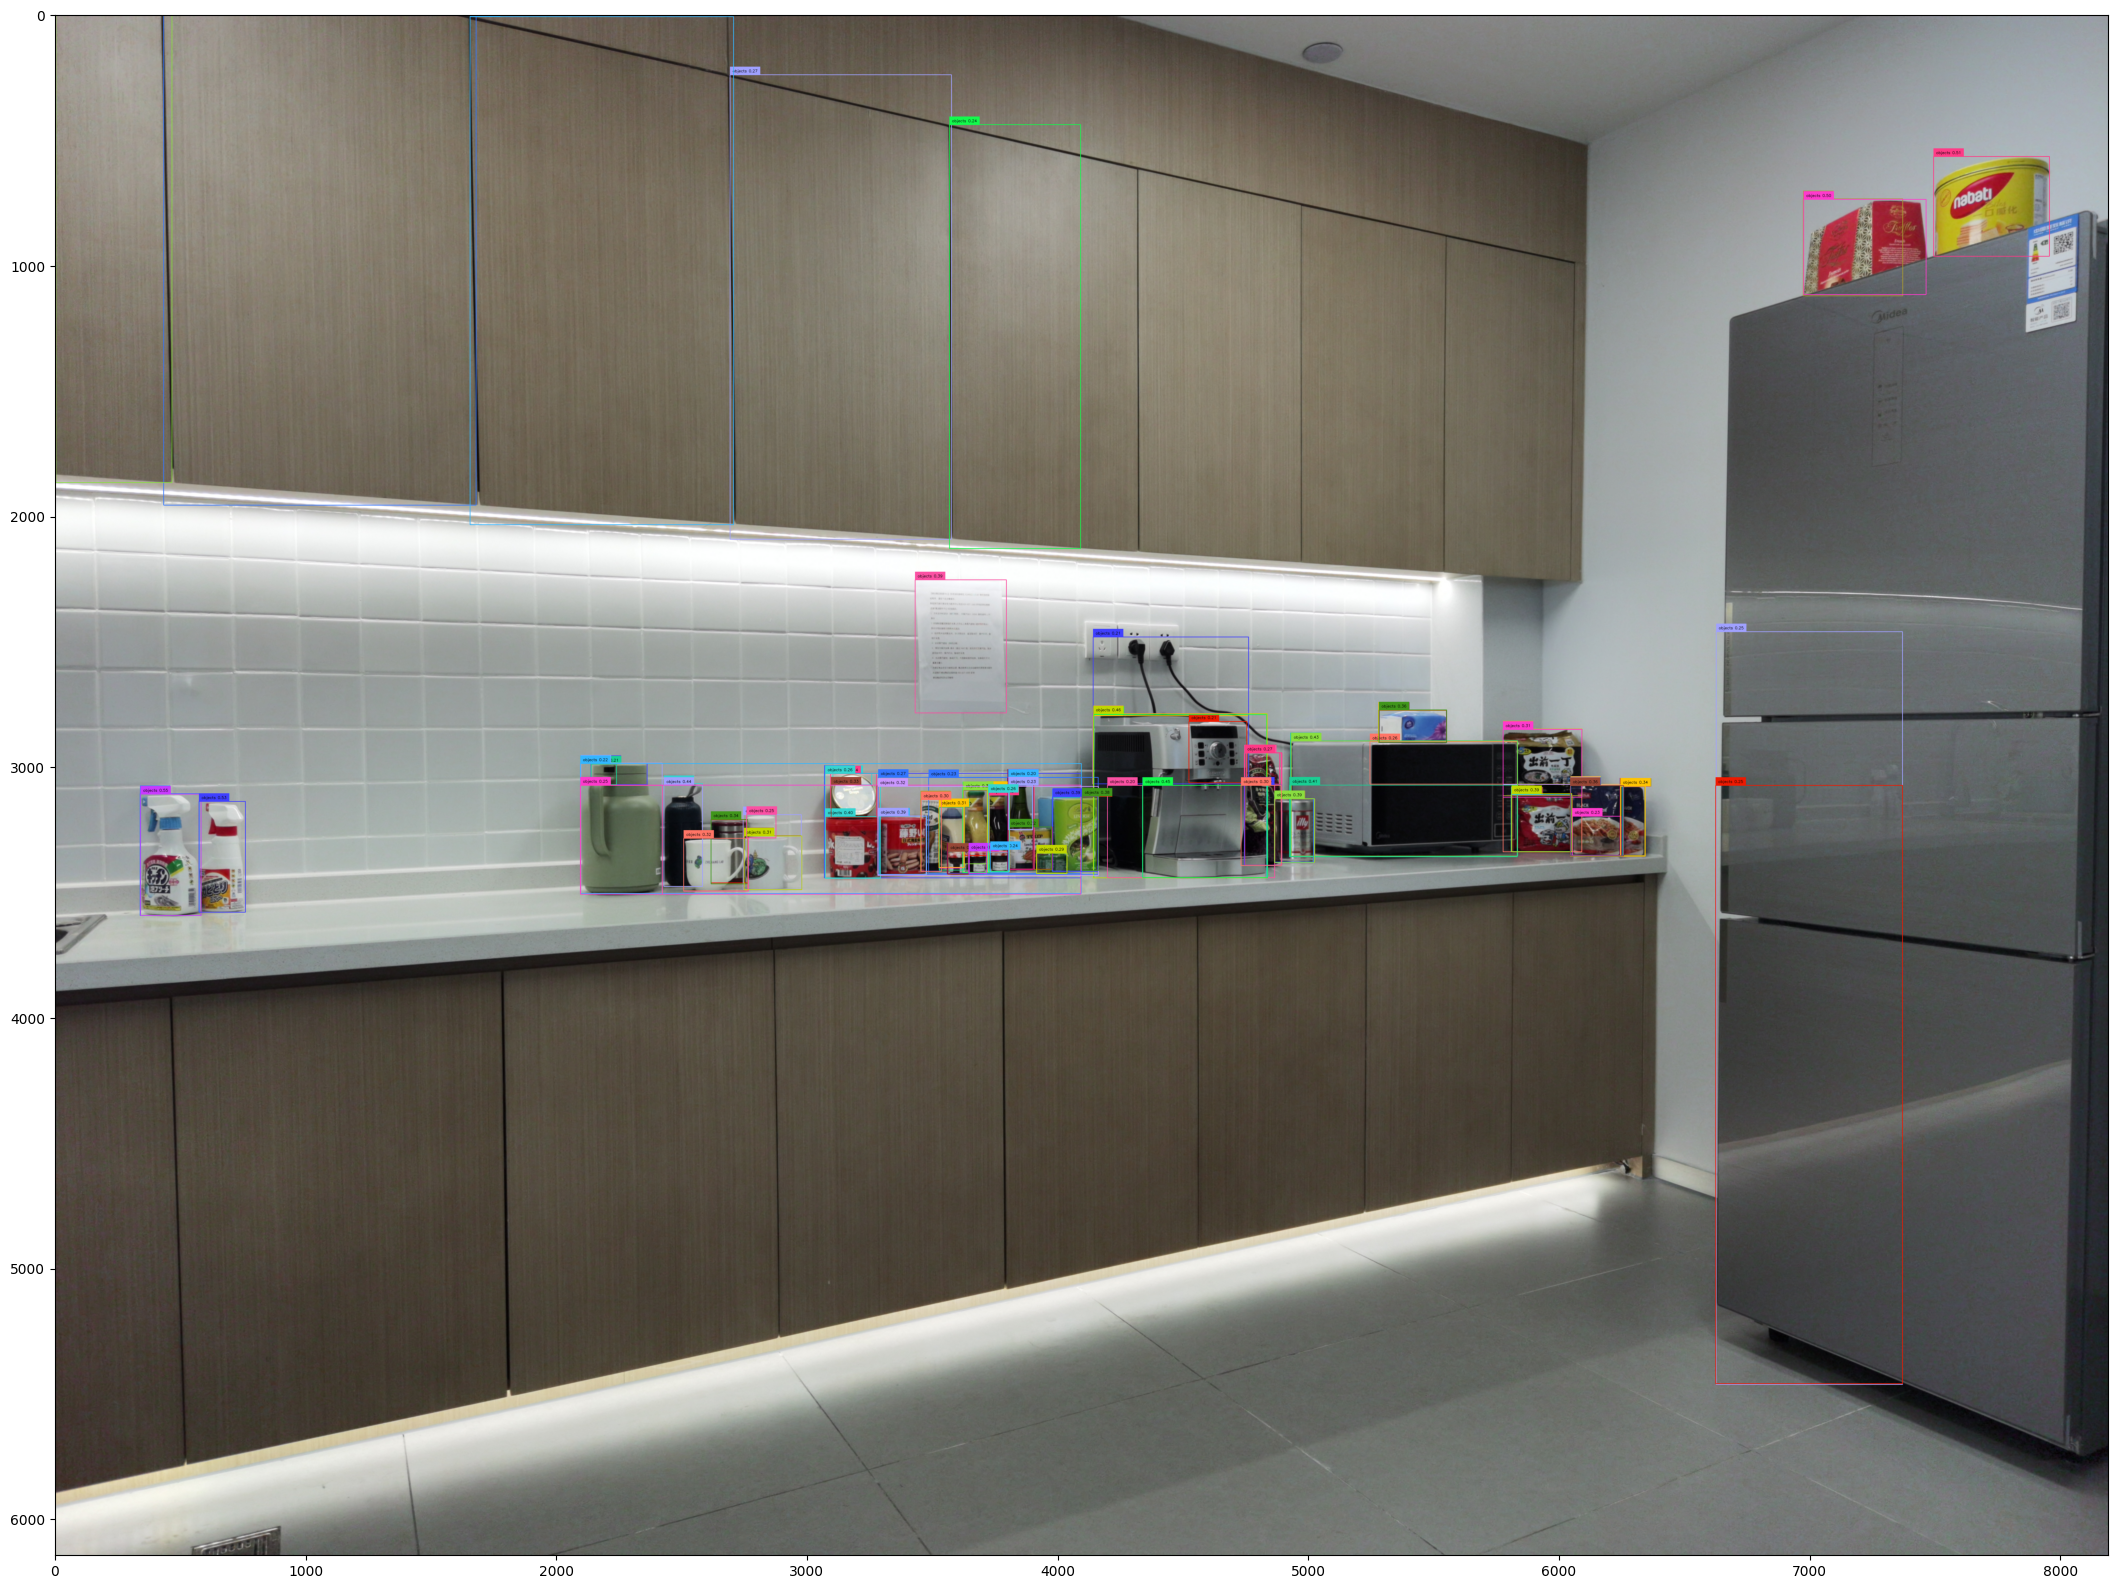

In [9]:
import matplotlib.pyplot as plt

bbox_annotated_pil = annotate(image, all_bboxes, all_confs, all_phrases)
# bbox_annotated_pil.show()
plt.figure(figsize=(50,20))
plt.imshow(bbox_annotated_pil)

final text_encoder_type: bert-base-uncased
Model loaded from C:\Users\divya\.cache\huggingface\hub\models--ShilongLiu--GroundingDINO\snapshots\a94c9b567a2a374598f05c584e96798a170c56fb\groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


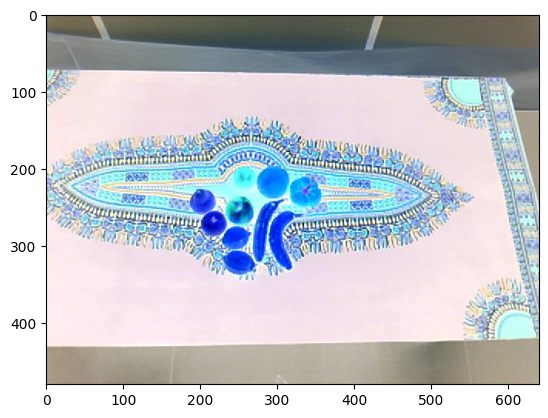

In [102]:
import matplotlib.pyplot as plt
image_pil = PILImg.open(image_path).convert("RGB")
inverse = PIL.ImageOps.invert(image_pil)
plt.imshow(inverse)
gdino = GroundingDINOObjectPredictor(use_vitb=False, box_threshold=0.2, text_threshold=0.2)
bboxes, phrases, gdino_conf = gdino.predict(inverse, text_prompt)
w, h = inverse.size
xyxy = gdino.bbox_to_scaled_xyxy(bboxes, w, h).detach().cpu().numpy()

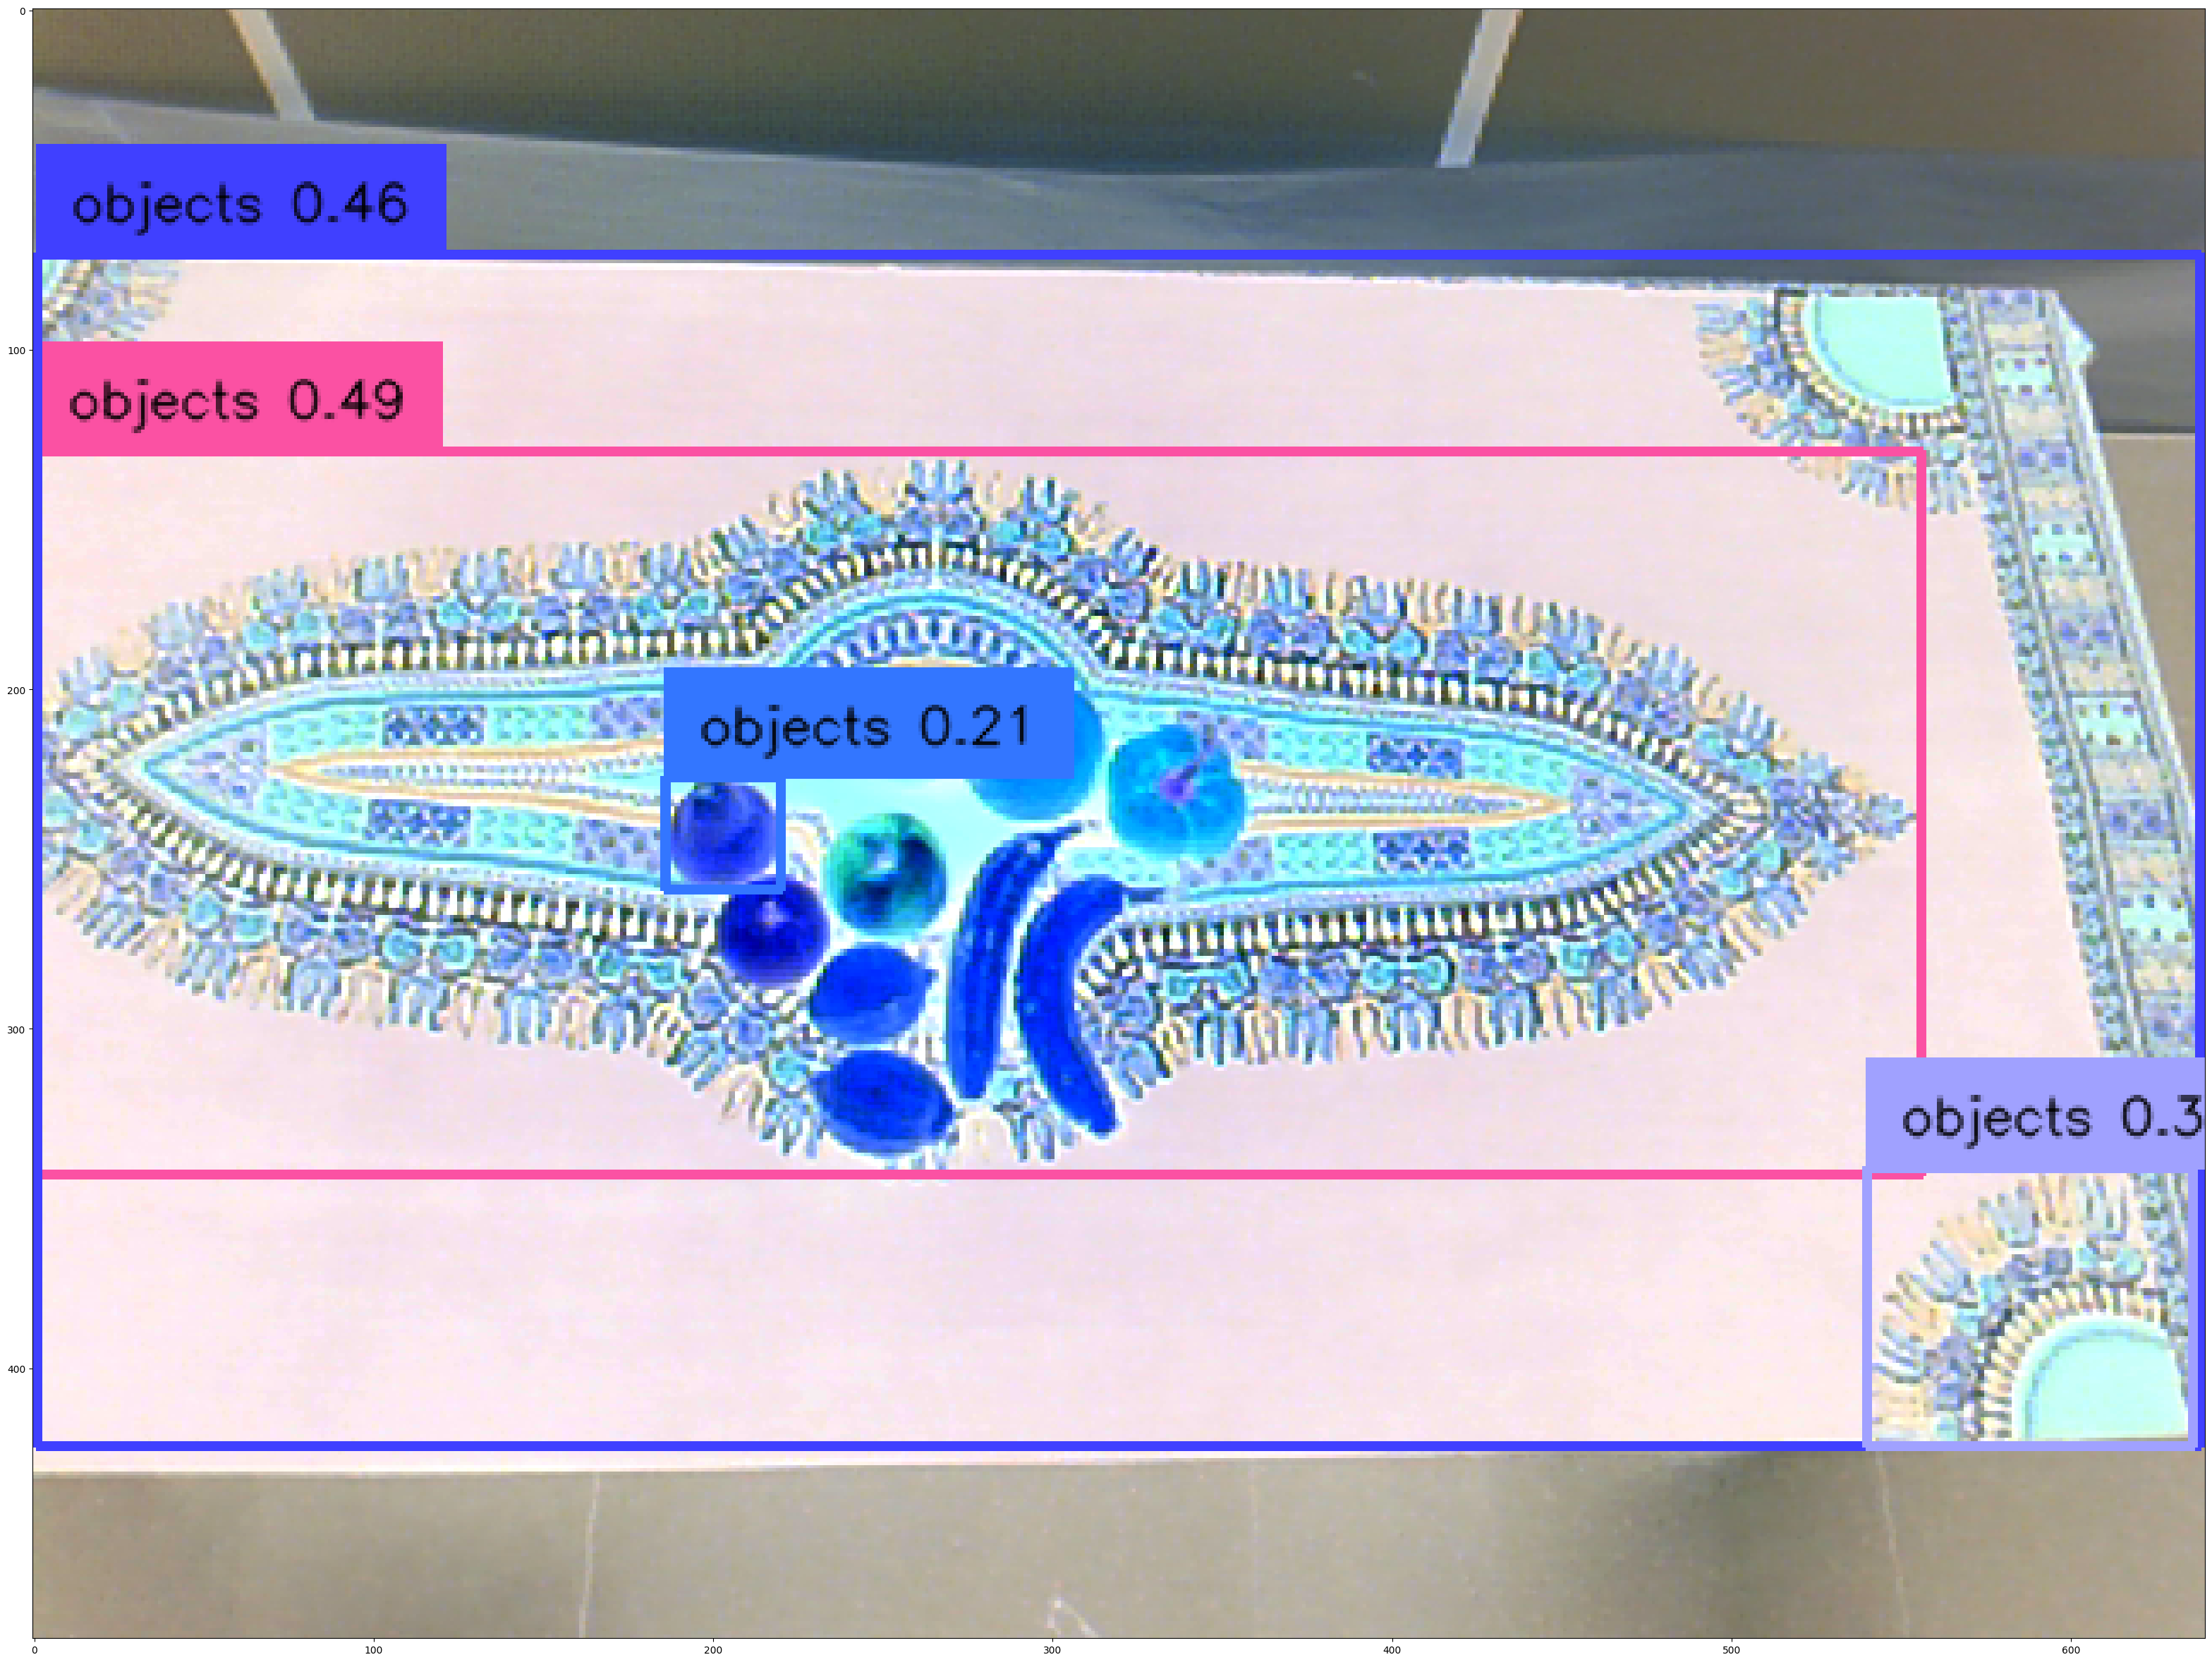

In [103]:
bbox_annotated_pil = annotate(inverse, xyxy, gdino_conf, phrases)
plt.figure(figsize=(60,30))
plt.imshow(bbox_annotated_pil)

In [80]:
for i, (bb, wid) in enumerate(zip(all_bboxes, window_id)):
    s=area(bb)
    b=area(all_windows[wid])
    print(f"{i}] {bb} >> {area(bb)} || {wid}. {all_windows[wid]} >> {area(all_windows[wid])} || Ratio is {int((s/b)*100)}")

0] [4301, 1841, 4669, 2046] >> 75440 || 1. [2184, 0, 4914, 2048] >> 5591040 || Ratio is 1
1] [2186, 0, 2559, 1543] >> 575539 || 1. [2184, 0, 4914, 2048] >> 5591040 || Ratio is 10
2] [1167, 2719, 1464, 3200] >> 142857 || 4. [0, 1639, 2730, 3687] >> 5591040 || Ratio is 2
3] [2243, 2807, 2719, 3197] >> 185640 || 4. [0, 1639, 2730, 3687] >> 5591040 || Ratio is 3
4] [896, 2758, 1148, 3201] >> 111636 || 4. [0, 1639, 2730, 3687] >> 5591040 || Ratio is 1
5] [88, 2281, 415, 3217] >> 306072 || 4. [0, 1639, 2730, 3687] >> 5591040 || Ratio is 5
6] [1, 3187, 1143, 3405] >> 248956 || 4. [0, 1639, 2730, 3687] >> 5591040 || Ratio is 4
7] [2751, 2763, 3190, 3199] >> 191404 || 5. [2184, 1639, 4914, 3687] >> 5591040 || Ratio is 3
8] [3190, 2631, 3600, 3202] >> 234110 || 5. [2184, 1639, 4914, 3687] >> 5591040 || Ratio is 4
9] [4010, 2559, 4272, 3112] >> 144886 || 5. [2184, 1639, 4914, 3687] >> 5591040 || Ratio is 2
10] [3766, 2711, 3920, 3121] >> 63140 || 5. [2184, 1639, 4914, 3687] >> 5591040 || Ratio is